#### 5.2 합성곱 신경망

In [9]:
# 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms     # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

In [2]:
# CPU 혹은 GPU 장치 확인
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 하나의 GPU를 사용할때는 위와 같이 쓰지만 다수의 GPU를 사용하면 nn.Parallel을 이용
# nn.Parallel을 사용할 때는 배치크기가 알아서 각 GPU로 분배됨 => GPU 수만큼 배치크기도 늘려야함

In [5]:
# fashion_mnist 데이터셋 내려받기
train_dataset = torchvision.datasets.FashionMNIST("../data", download=True, transform=transforms.Compose([transforms.ToTensor()]))
# download=True : 해당 데이터가 폴더에 있는지 확인 후 내려받음 / transform : 이미지를 텐서(0~1)로 변경
test_dataset = torchvision.datasets.FashionMNIST("../data", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

100.0%


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



In [6]:
# fashion_mnist 데이터를 데이터 로더에 전달
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
# DataLoader()를 사용하여 원하는 크기의 배치 단위를 데이터를 불러오거나 순서가 무작위로 섞이도록 할 수 있음
# 데이터를 불러올 데이터셋을 지정한 뒤 배치로 묶어줌 (100개 단위로 묶어서 불러옴)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

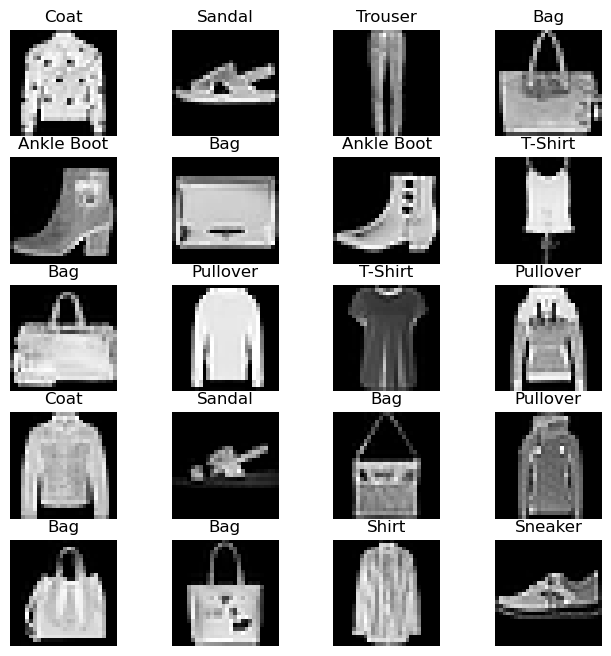

In [7]:
# 분류에 사용될 클래스 정의
labels_map = {0:'T-Shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'}

fig = plt.figure(figsize=(8,8)) # 단위 : inch
columns = 4
rows = 5
for i in range(1,columns*rows+1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0,:,:]       # train_dataset을 이용한 3차원 배열
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [11]:
# 심층 신경망 모델 생성
class FashionDNN(nn.Module):
    def __init__(self) : 
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256)
        self.drop = nn.Dropout(0.25)    # 0.25만큼의 비율로 텐서의 값이 0이 되고 0이 되지 않는 값들은 기존값에 1/0.75만큼 곱해져 커짐
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
    
    def forward(self, input_data):      # forward 이름 틀리면 절대 안됨!
        out = input_data.view(-1,784)   # 넘파이의 reshape과 같이 텐서의 크기를 변경해줌 => 2차원의 텐서로 변경하되 (?,784)의 크기로 파이토치의 재량에 맞춰 크기 변경
        out = F.relu(self.fc1(out))     # 활성화 함수 지정 방법 - 1. forward()함수에서 정의    2. __init__()함수에서 정의
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

![스크린샷 2024-09-25 175824.png](<attachment:스크린샷 2024-09-25 175824.png>)
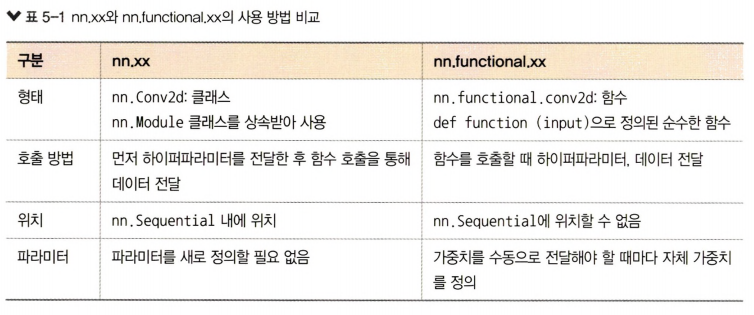

In [12]:
# 심층 신경망에서 필요한 파라미터 정의
learning_rate = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)      # 경사하강법 : Adam 사용
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [14]:
# 심층 신경망을 이용한 모델 학습
num_epochs = 5
count = 0
loss_list = []
itertation_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)       # 모델이 데이터를 처리하기 위해서는 모델과 데이터가 동일한 장치에 있어야함

        train = Variable(images.view(100,1,28,28))                  
        # Autograd : 자동 미분을 수행 이 값을 저장하기 위해 tape를 사용 => 순전파 단계에서 수행하는 모든 연산을 테이프가 저장하고 역전파 단계에서 그 값들을 꺼내 사용함 
        # => Variable을 사용해 역전파을 위한 미분값 자동으로 계산
        labels = Variable(labels)

        outputs = model(train)  # 학습 데이터를 모델에 적용
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not count%50 :
            total = 0
            correct = 0

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                outputs = model(test)
                predictions = torch.max(outputs,1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total                    # 정확도 : 전체 예측에 대한 정확한 예측의 비율로 표현 => 퍼센트를 위해 100을 곱해줌
            loss_list.append(loss.data)
            itertation_list.append(count)
            accuracy_list.append(accuracy)
        if not count%500:
            print(f'Iteration : {count}, Loss : {loss.data}, Accuracy : {accuracy}')

Iteration : 500, Loss : 0.49658501148223877, Accuracy : 84.66999816894531
Iteration : 1000, Loss : 0.46882614493370056, Accuracy : 84.8499984741211
Iteration : 1500, Loss : 0.34426647424697876, Accuracy : 85.25
Iteration : 2000, Loss : 0.3419085741043091, Accuracy : 85.66000366210938
Iteration : 2500, Loss : 0.21428872644901276, Accuracy : 86.66000366210938
Iteration : 3000, Loss : 0.32842183113098145, Accuracy : 87.1500015258789


In [15]:
# 합성곱 네트워크 생성
class FashionCNN(nn.Module):
    def __init__(self) :
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), nn.BatchNorm2d(32), 
                                    nn.ReLU(),nn.MaxPool2d(kernel_size=2,stride=2))
        # nn.Sequential : 계층을 차례로 쌓을 수 있도록 수식과 활성화 함수를 연결하는 역할을 함, 데이터가 각 계층을 순차적으로 지나갈 때 사용하면 좋음
        #                 여러개의 계층을 하나의 컨테이너에 구현하는 방법
        # 합성곱층 : 합성곱 연산을 통해 이미지 특징 추출 / n*m크기의 커널(또는 필터)이 이미지를 처음부터 끝까지 훑으면서 각 원소 값끼리 곱한 후 모두 더한 값을 출력
        #           커널은 일반적으로 3x3 또는 5x5를 사용함
        # BatchNorm2d : 학습 과정에서 각 배치 단위별로 평균과 분산을 이용하여 데이터를 정규화 하는 것 / 가우시안 형태 분포로 만듦(평균 0, 표준편차 1)
        # MaxPool2d : 이미지 크기를 축소 시킴 / 합성곱층의 출력 데이터를 입력으로 받아서 출력데이터의 크기를 줄이거나 특정 데이터를 강조하는 용도로 사용 (종류 : 최대, 평균, 최소)
        # kernel_size = m*n 행렬로 구성된 가중치
        # stride : 입력 데이터에 커널을 적용할 때 이동할 간격 / 스트라이드 값이 커지면 출력 크기는 작아짐
        # 클래스를 분류하기 위해 이미지 형태의 데이터를 배열 형태로 변환하여 작업 => 줄어든 출력 크기는 완전연결층(fully connected layer)에 전달되어 분류 실시
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3), nn.BatchNorm2d(64),
                                    nn.ReLU(), nn.MaxPool2d(2))
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        # UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. 
        # To retain the behavior and silence this warning, please use dropout instead. ====> Dropout2d 말고 Dropout 사용!!
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)  # 마지막 층의 out_features : 클래스 개수
    
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0),-1)
        # 합성곱층 -> 완전연결층으로 변경 => 데이터 형태를 1차원으로 바꿔줌 / out_size(0) : 100 ==> (100,?)크기의 텐서로 변경
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

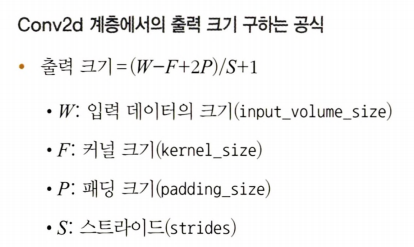
![스크린샷 2024-09-25 202304.png](<attachment:스크린샷 2024-09-25 202304.png>)
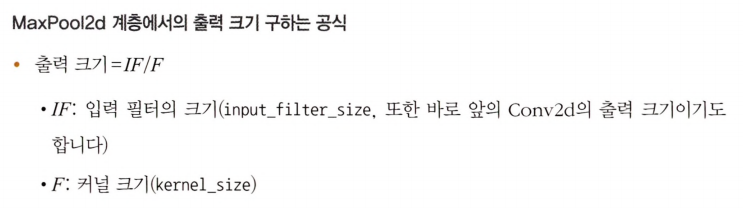

In [16]:
# 합성곱 네트워크를 위한 파라미터 정의
learning_rate = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [17]:
# 모델 학습 및 성능 평가
num_epochs = 5
count = 0
loss_list = []
itertation_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        train = Variable(images.view(100,1,28,28))                  
        labels = Variable(labels)

        outputs = model(train)  
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not count%50 :
            total = 0
            correct = 0

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                outputs = model(test)
                predictions = torch.max(outputs,1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total                   
            loss_list.append(loss.data)
            itertation_list.append(count)
            accuracy_list.append(accuracy)
        if not count%500:
            print(f'Iteration : {count}, Loss : {loss.data}, Accuracy : {accuracy}')

c:\Users\kdp\anaconda3\envs\TORCH_CV_38\lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration : 500, Loss : 0.5233643651008606, Accuracy : 87.62000274658203
Iteration : 1000, Loss : 0.31061697006225586, Accuracy : 88.66999816894531
Iteration : 1500, Loss : 0.29993605613708496, Accuracy : 88.55000305175781
Iteration : 2000, Loss : 0.1963699758052826, Accuracy : 89.12999725341797
Iteration : 2500, Loss : 0.12327855080366135, Accuracy : 89.58000183105469
Iteration : 3000, Loss : 0.17778153717517853, Accuracy : 90.29000091552734


In [ ]:
# 심층 신경망과 비교해 합성곱 네트워크의 정확도가 조금 더 높음 ==> 
# 실제로 이미지 데이터가 많아지면 단순 심층 신경망으로는 정확한 특성 추출 및 분류가 불가능 ==> 합성곱 신경망을 생성할 수 있도록 학습!!!